In [1]:
!pip install -q transformers peft datasets accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.8 MB/s eta 0:00:00


#  CONFIGURATION

In [2]:
import json
import torch
from datasets import Dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

MODEL_NAME = "google/flan-t5-base"
DATA_FILE = "banking_dataset.json"
OUTPUT_DIR = "./banking_assistant_lora"
NUM_EPOCHS = 3
BATCH_SIZE = 8

# Load Dataset

In [4]:
def load_and_format_data(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)

    formatted_data = []
    for item in data:
        formatted_data.append({
            "input_text": f"banking_assistant: {item['instruction']}",
            "target_text": item['response']
        })
    return Dataset.from_list(formatted_data)

dataset = load_and_format_data(DATA_FILE)

# Split into train/test/validation

In [5]:
dataset = dataset.train_test_split(test_size=0.1)
print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['test'])}")

Training samples: 720
Validation samples: 80


# Tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    model_inputs = tokenizer(examples["input_text"], max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(examples["target_text"], max_length=128, truncation=True, padding="max_length")

    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

# Load Model with LoRA

In [7]:
#load base model
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float32)

# Define LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Apply LoRA to the model

In [8]:
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

trainable params: 1,769,472 || all params: 249,347,328 || trainable%: 0.7096


#Training Arguments

In [9]:
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=3e-4,
    num_train_epochs=5,
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_strategy="steps",
    logging_steps=20,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=False,
)

#Trainer

In [10]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model)
)

print("Starting training...")
trainer.train()

/tmp/ipython-input-762735720.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Starting training...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anujananu812 (anujananu812-university-of-moratuwa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,2.046800,1.496319
2,1.090500,0.661210
3,0.794400,0.411531


Epoch,Training Loss,Validation Loss
1,2.046800,1.496319
2,1.090500,0.661210
3,0.794400,0.411531
4,0.627800,0.346995
5,0.578300,0.324698


TrainOutput(global_step=450, training_loss=1.207777435514662, metrics={'train_runtime': 565.9482, 'train_samples_per_second': 6.361, 'train_steps_per_second': 0.795, 'total_flos': 621173853388800.0, 'train_loss': 1.207777435514662, 'epoch': 5.0})

In [11]:
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

('./banking_assistant_lora/tokenizer_config.json',
 './banking_assistant_lora/special_tokens_map.json',
 './banking_assistant_lora/spiece.model',
 './banking_assistant_lora/added_tokens.json',
 './banking_assistant_lora/tokenizer.json')

#Evaluation & Visualization

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

#Plot training loss

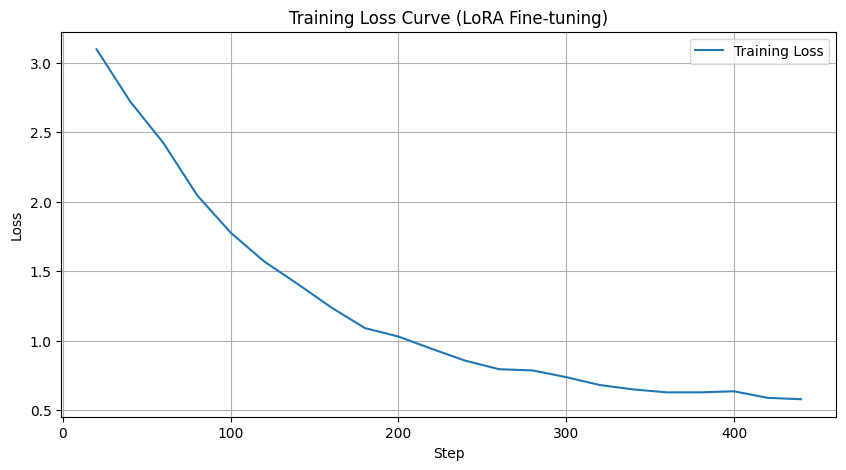

In [13]:
history = trainer.state.log_history
loss_data = {'step': [], 'loss': []}

for entry in history:
    if 'loss' in entry:
        loss_data['step'].append(entry['step'])
        loss_data['loss'].append(entry['loss'])

plt.figure(figsize=(10, 5))
plt.plot(loss_data['step'], loss_data['loss'], label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Curve (LoRA Fine-tuning)')
plt.legend()
plt.grid(True)
plt.savefig("training_loss.png")
plt.show()

#Compare Base vs Fine-Tuned

In [15]:
import pandas as pd
from transformers import pipeline

print("\n--- Generating Comparisons (Base vs Fine-Tuned) ---")

test_prompts = [
    "I lost my credit card, help!",
    "What is the balance of my Savings account?",
    "Transfer 500 to Mom.",
    "When does the bank close?",
    "Can I get a home loan?",
    "My platinum card was stolen.",
    "Send 200.50 to Alice.",
    "Do you are open on Sundays?",
    "What is the interest rate for a car loan?",
    "I need to block my debit card."
]

def generate_response(model, tokenizer, prompt):
    # Standard T5 format
    input_text = f"Instruction: {prompt}"
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

    # Generate
    outputs = model.generate(**inputs, max_new_tokens=64)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

results = []

print(f"{'Instruction':<40} | {'BASE Model (Before)':<30} | {'FINE-TUNED (After)'}")
print("-" * 110)

for prompt in test_prompts:
    # 1. Get Fine-Tuned Response
    ft_response = generate_response(model, tokenizer, prompt)

    # 2. Get Base Model Response (Temporarily disable LoRA)
    with model.disable_adapter():
        base_response = generate_response(model, tokenizer, prompt)

    print(f"{prompt:<40} | {base_response:<30} | {ft_response}")

    results.append({
        "instruction": prompt,
        "base_model": base_response,
        "fine_tuned_model": ft_response
    })

# Save comparisons to CSV for your submission
df = pd.DataFrame(results)
df.to_csv("model_comparison.csv", index=False)
print("\nSuccess! Saved comparison results to 'model_comparison.csv'")


--- Generating Comparisons (Base vs Fine-Tuned) ---
Instruction                              | BASE Model (Before)            | FINE-TUNED (After)
--------------------------------------------------------------------------------------------------------------
I lost my credit card, help!             | I lost my credit card, help!   | I have locked your credit card temporarily. Please check your mobile app to permanently block it or request a replacement.
What is the balance of my Savings account? | 0                              | The balance of your Savings is $2682.00.
Transfer 500 to Mom.                     | 500 to Mom.                    | Transfer request for 500 received. Please verify the recipient's details before I confirm.
When does the bank close?                | late at night                  | We are currently closed. Our hours are 9 AM to 5 PM, Monday through Friday.
Can I get a home loan?                   | Yes                            | You can apply for a Home Loa